In [176]:
import pandas as pd
import numpy as np
import sys
import folium
import folium.plugins as fp
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
import geopandas as gpd
from shapely.ops import nearest_points
from shapely.geometry import LineString

In [177]:
vancouver=pd.read_json('amenities-vancouver.json',lines=True)
vancouver=vancouver.dropna()

In [178]:
amenity=vancouver.groupby('amenity').count()
#amenity.to_csv('numberofamenities.csv')
amenity=amenity.reset_index() 

In [179]:
AirbnbListings=pd.read_csv('listings.csv')

In [180]:
#for col in AirbnbListings.columns:
#    print(col)

In [181]:
AirbnbListings=AirbnbListings[AirbnbListings['review_scores_rating']>80]
AirbnbListings=AirbnbListings[AirbnbListings['number_of_reviews']>90]
AirbnbListings=AirbnbListings[AirbnbListings['last_review']>'2020-01-01']
AirbnbListings=AirbnbListings[['id','latitude','longitude','amenities','review_scores_accuracy',
                               'review_scores_cleanliness','review_scores_checkin',
                               'review_scores_communication','price',
                               'review_scores_value','review_scores_rating']]
AirbnbListings=AirbnbListings.dropna()
AirbnbListings=AirbnbListings.rename(columns={'latitude':'lat','longitude':'lon'})

In [182]:
#just checking how the join would work
#pd.merge(vancouver,AirbnbListings,how='outer',left_on=['lat'],right_on=['latitude'])


In [183]:
outdooracivties = vancouver[(vancouver['amenity'] == 'bicycle_rental')|(vancouver['amenity'] == 'boat_rental')|
                            (vancouver['amenity'] == 'leisure')|(vancouver['amenity'] == 'park')]

In [184]:
nightlife = vancouver[(vancouver['amenity']=='bar')|(vancouver['amenity']=='lounge')|(vancouver['amenity']=='nightclub')|
                      (vancouver['amenity']=='stripclub')|(vancouver['amenity']=='pub')
                     |(vancouver['amenity']=='internet_cafe')|(vancouver['amenity']=='casino')]

In [185]:
food = vancouver[(vancouver['amenity']=='bbq')| (vancouver['amenity']=='restaurant')|(vancouver['amenity']=='ice_cream')|
                 (vancouver['amenity']=='bistro')| (vancouver['amenity']=='cafe')]


In [186]:
allactivities = outdooracivties.append(nightlife).append(food)


In [187]:
def color_of_map(vancouver):
    if((vancouver['amenity'] == 'bicycle_rental')|(vancouver['amenity'] == 'boat_rental')|
                            (vancouver['amenity'] == 'leisure')|(vancouver['amenity'] == 'park')):
        return 'red'
    elif ((vancouver['amenity']=='bar')|(vancouver['amenity']=='lounge')|(vancouver['amenity']=='nightclub')|
                      (vancouver['amenity']=='stripclub')|(vancouver['amenity']=='pub')
                     |(vancouver['amenity']=='internet_cafe')|(vancouver['amenity']=='casino')):
        return 'purple'
    elif (vancouver['amenity']=='restaurant'):
        return 'pink'
    elif (vancouver['amenity']=='cafe'):
        return 'green'
    else:
        return 'blue'

In [188]:
def make_circle(data, group, radius=1):
    folium.CircleMarker(
        location=[data['lat'], data['lon']],
        radius=radius,
        color = color_of_map(data)
    ).add_to(group)

In [189]:
def make_circle_Airbnb(data, group, c , radius=1):
    folium.CircleMarker(
        location=[data['lat'], data['lon']],
        radius=radius,
        color = c
    ).add_to(group,)

In [190]:
def circle_of_amenities(df):
    van_map = folium.Map(location=[49.14, -122.65], zoom_start=10)
    activites = folium.map.FeatureGroup()
    df.apply(make_circle, axis=1, group=activites)
    return van_map.add_child(activites)

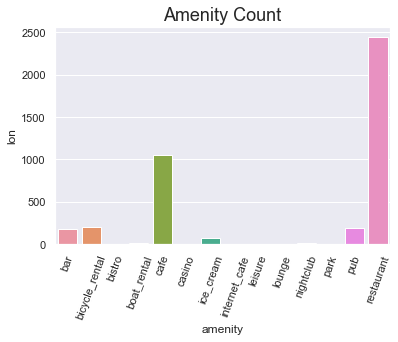

In [191]:
AmenityCount = allactivities.groupby('amenity').count().reset_index()
sns.set()
pic = sns.barplot(AmenityCount['amenity'],AmenityCount['lon'])
plt.xticks(rotation=70)
plt.title('Amenity Count',fontsize = 18)
plt.show()

In [192]:
circle_of_amenities(allactivities)

In [193]:
def create_gdf(df, x="lon", y="lat"):
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]), crs={"init":"epsg:4326"})

In [194]:
# adapted from https://automating-gis-processes.github.io/2017/lessons/L3/nearest-neighbour.html
def calculate_nearest(row, destination, val, col="geometry"):
    dest_unary = destination["geometry"].unary_union
    nearest_geom = nearest_points(row[col], dest_unary)
    match_geom = destination.loc[destination.geometry == nearest_geom[1]]
    match_value = match_geom[val].to_numpy()[0]
    return match_value

In [195]:
AirbnbListings_gdf = create_gdf(AirbnbListings)
vancouver_gdf = create_gdf(allactivities)

c:\users\bobby\desktop\cmpt353\env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [196]:
AirbnbListings_gdf["nearest_point"] = AirbnbListings_gdf.apply(calculate_nearest, 
                                                              destination=vancouver_gdf, val="geometry", axis=1)

In [197]:

AirbnbListings_gdf["nearest_amenity"] = AirbnbListings_gdf.apply(calculate_nearest, 
                                                                destination=vancouver_gdf, val="amenity", axis=1)

In [198]:
AirbnbListings_gdf['line'] = AirbnbListings_gdf.apply(lambda row: LineString([row['geometry'], row['nearest_point']]), axis=1)

In [199]:

line_gdf = AirbnbListings_gdf[["id","nearest_amenity", "line"]].set_geometry('line')

In [200]:
line_gdf.crs = crs={"init":"epsg:4326"}

c:\users\bobby\desktop\cmpt353\env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [201]:
AirbnbListings_gdf.drop(["nearest_point", "line"], axis=1, inplace=True)

In [202]:
m = folium.Map([49.14, -122.65],
               zoom_start = 10)

hotel =folium.map.FeatureGroup()
activitiesHotel = folium.map.FeatureGroup()

AirbnbListings.iloc[:,1:3].apply(make_circle_Airbnb, axis=1, group=hotel,c ="orange", radius =2)
allactivities.apply(make_circle, axis=1, group=activitiesHotel,radius=2)

hotel.add_to(m)
activitiesHotel.add_to(m)
folium.GeoJson(line_gdf).add_to(m)

m

In [203]:
cafe =vancouver[(vancouver['amenity']=='cafe')]
cafe = cafe[cafe['lat']<=49.313138]
cafe = cafe[cafe['lat']>=49.201832]
cafe = cafe[cafe['lon']>=-123.252683]
cafe = cafe[cafe['lon']<=-123.025747]

In [204]:
AirbnbListings_gdf = create_gdf(AirbnbListings)
vancouver_gdf = create_gdf(cafe)

In [205]:
vancouver_gdf["nearest_point"] = vancouver_gdf.apply(calculate_nearest, 
                                                     destination=AirbnbListings_gdf, val="geometry", axis=1)

In [206]:
vancouver_gdf["nearest_id"] = vancouver_gdf.apply(calculate_nearest, 
                                                     destination=AirbnbListings_gdf, val="id", axis=1)

In [207]:
vancouver_gdf['line'] = vancouver_gdf.apply(lambda row: LineString([row['geometry'], row['nearest_point']]), axis=1)

In [208]:
line_gdf = vancouver_gdf[["nearest_id", "line"]].set_geometry('line')

In [209]:
line_gdf.crs = crs={"init":"epsg:4326"}

c:\users\bobby\desktop\cmpt353\env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [210]:
vancouver_gdf.drop(["nearest_point", "line"], axis=1, inplace=True)

In [211]:
m = folium.Map([49.14, -122.65],
               zoom_start = 10)

hotel =folium.map.FeatureGroup()
activitiesHotel = folium.map.FeatureGroup()

AirbnbListings.iloc[:,1:3].apply(make_circle_Airbnb, axis=1, group=hotel,c ="orange", radius =2)
cafe.apply(make_circle, axis=1, group=activitiesHotel,radius=2)

hotel.add_to(m)
activitiesHotel.add_to(m)
folium.GeoJson(line_gdf).add_to(m)

m

In [212]:
vancouver_gdf

lat         lon                      timestamp amenity  \
0      49.260812 -123.125736  2020-03-20T18:22:12.000-07:00    cafe   
83     49.263582 -123.128836  2019-05-04T04:55:51.000-07:00    cafe   
115    49.268572 -123.104526  2018-10-26T20:30:44.000-07:00    cafe   
303    49.282155 -123.099839  2019-09-13T13:57:03.000-07:00    cafe   
306    49.283173 -123.093516  2019-09-13T13:57:03.000-07:00    cafe   
...          ...         ...                            ...     ...   
17561  49.236050 -123.041102  2019-09-13T13:57:05.000-07:00    cafe   
17631  49.227010 -123.128733  2019-07-16T20:38:16.000-07:00    cafe   
17646  49.263792 -123.140062  2019-09-13T13:57:05.000-07:00    cafe   
17701  49.262659 -123.251745  2019-11-04T20:07:41.000-08:00    cafe   
17706  49.264044 -123.174166  2019-09-13T13:56:49.000-07:00    cafe   

                    name                                               tags  \
0              Starbucks  {'brand:wikidata': 'Q37158', 'official_name': ...   
83                 Waves  {'opening_hours': 'Mo-Fr 06:00-24:00; Sa-Su 08...   
115            Argo Cafe  {'addr:housenumber': '1836', 'addr:street': 'O...   
303         Waves Coffee  {'addr:housenumber': '305', 'addr:street': 'Ma...   
306    The Uncommon Cafe  {'addr:housenumber': '477', 'addr:street': 'Po...   
...                  ...                                                ...   
17561          Café Foam  {'addr:housenumber': '3003', 'addr:street': 'K...   
17631          Jazen Tea  {'cuisine': 'bubble_tea;smoothie;fruit_tea', '...   
17646            Chatime  {'brand:wikidata': 'Q16829306', 'brand:en': 'C...   
17701         Magma Cafè  {'wheelchair': 'yes', 'addr:housenumber': '633...   
17706        Tim Hortons  {'brand:wikidata': 'Q175106', 'addr:housenumbe...   

                          geometry  nearest_id  
0      POINT (-123.12574 49.26081)     2811792  
83     POINT (-123.12884 49.26358)    22729409  
115    POINT (-123.10453 49.26857)    20743705  
303    POINT (-123.09984 49.28216)    26956652  
306    POINT (-123.09352 49.28317)     7804061  
...                            ...         ...  
17561  POINT (-123.04110 49.23605)    33683081  
17631  POINT (-123.12873 49.22701)    14884432  
17646  POINT (-123.14006 49.26379)    12561247  
17701  POINT (-123.25174 49.26266)    11950920  
17706  POINT (-123.17417 49.26404)    26062493  

[557 rows x 8 columns]

In [213]:
vancouver_gdf.groupby(['nearest_id']).count().reset_index().sort_values(by='lat',ascending =False)

nearest_id  lat  lon  timestamp  amenity  name  tags  geometry
76     11950920   21   21         21       21    21    21        21
12      1273760   19   19         19       19    19    19        19
197    27399165   13   13         13       13    13    13        13
107    15985271   12   12         12       12    12    12        12
139    19946831   12   12         12       12    12    12        12
..          ...  ...  ...        ...      ...   ...   ...       ...
114    17209424    1    1          1        1     1     1         1
111    16606630    1    1          1        1     1     1         1
41      5384454    1    1          1        1     1     1         1
109    16491614    1    1          1        1     1     1         1
0         13188    1    1          1        1     1     1         1

[213 rows x 8 columns]

In [218]:
thewiningHotel = AirbnbListings[(AirbnbListings['id']==1273760)]

In [219]:
thewiningHotel

id      lat        lon  \
144  1273760  49.2858 -123.11767   

                                             amenities  \
144  {TV,Wifi,Kitchen,"Family/kid friendly","Smoke ...   

     review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
144                    10.0                       10.0                   10.0   

     review_scores_communication    price  review_scores_value  \
144                         10.0  $150.00                  8.0   

     review_scores_rating                     geometry  \
144                  97.0  POINT (-123.11767 49.28580)   

                       nearest_point  
144  POINT (-123.1171956 49.2854943)

In [220]:
m = folium.Map([49.14, -122.65],
               zoom_start = 10)

hotel =folium.map.FeatureGroup()
activitiesHotel = folium.map.FeatureGroup()

thewiningHotel.iloc[:,1:3].apply(make_circle_Airbnb, axis=1, group=hotel,c ="orange", radius =2)
cafe.apply(make_circle, axis=1, group=activitiesHotel,radius=2)

hotel.add_to(m)
activitiesHotel.add_to(m)


m

In [221]:
AirbnbListings['lat']

1       49.24577
10      49.27427
12      49.28251
15      49.23365
16      49.23427
          ...   
3166    49.27869
3215    49.24111
3315    49.28634
3371    49.24912
3406    49.26461
Name: lat, Length: 561, dtype: float64